In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timewarp_lib.load_model as lm
import timewarp_lib.train_utils as tu
import torch
import pandas as pd
import json
import numpy as np
import matplotlib

/home/travers/miniconda3/envs/timewarpvae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmap = plt.get_cmap("viridis")

In [3]:

####clean_model_dirs = ["../results/overnight/20230921-093159.705744/savedmodel"] # TenDTWModel



In [4]:
import matplotlib
font = {        'size'   : 22}

matplotlib.rc('font', **font)

In [5]:
datatype = "train"
dtype=torch.float
device="cpu"
batch_size=100
training_data_timing_noise=0

dataName = "../data/trainTest2DLetterARescaled.npz"
# the datafile has information on how the data was cleaned
# the learned/applied model is on clean data
# so we need to convert back to trajectory data
loaded_data_dict = np.load(dataName)

ydata = torch.tensor(loaded_data_dict[datatype],dtype=dtype).to(device)
np_ydata = ydata.detach().cpu().numpy()
num_trajs, numts, traj_channels = ydata.shape
tdata = torch.tensor(np.linspace(0,1,numts),dtype=dtype).to(device).expand(num_trajs,numts).unsqueeze(2)

torch_train_data = torch.utils.data.TensorDataset(tdata, ydata)
training_dataloader = torch.utils.data.DataLoader(torch_train_data, batch_size=batch_size, shuffle=True)

In [6]:
ixs=(10,15)

In [7]:
import timewarp_lib.decoders as ds

In [8]:
def get_interps(saved_model_dir):
    pose_mean = loaded_data_dict["pose_mean"]
    pose_scaling = loaded_data_dict["pose_scaling"]

    modelApplier = lm.LoadedModel(saved_model_dir)
    modeldatafileobj = np.load(f"{saved_model_dir}/saved_model_info.npz",allow_pickle=True)
    modeldata = {key : (modeldatafileobj[key] if key != "initialization_function" else True) for key in modeldatafileobj.keys()}
    num_timesteps = 200
    num_channels = 2
    latent_dim = (int)(modeldata["latent_dim"])

    hi=modelApplier.model

    embeds,_ = hi.encoder.encode(ydata[ixs,],tdata[ixs,])
    embeds = embeds.detach().cpu().numpy()

    scaled_ts = hi.scalar_timewarper.timewarp(ydata[ixs,],tdata[ixs,]).detach().cpu().numpy()

    lambd = np.linspace(0,1,3)
    interpembeds = torch.tensor(np.array([embeds[0] * (1-l) + embeds[1] * (l) for l in lambd]))
    
    if type(modelApplier.model.decoder) is ds.RateInvariantDecoder:
        ria_T = modelApplier.model.decoder.T
        interpembeds[:,:ria_T] = np.sqrt(1/ria_T)
    
    canonical_ts = torch.tensor(np.array([np.array(tdata[0,] * (1-l) + tdata[1,] * (l)) for l in lambd]))
    canonicaltime_trajs = hi.decoder.decode(interpembeds, canonical_ts).detach().numpy()

    lambd2 = np.linspace(0,1,11)
    full_interpembeds = torch.tensor(np.array([embeds[0] * (1-l) + embeds[1] * (l) for l in lambd2]))
    if type(modelApplier.model.decoder) is ds.RateInvariantDecoder:
        # to prevent timewarping, reset the time-latents here
        ria_T = modelApplier.model.decoder.T
        full_interpembeds[:,:ria_T] = np.sqrt(1/ria_T)
    full_canonical_ts = torch.tensor(np.array([np.array(tdata[0,] * (1-l) + tdata[1,] * (l)) for l in lambd2]))
    full_canonicaltime_trajs = hi.decoder.decode(full_interpembeds, full_canonical_ts).detach().numpy()

    return canonical_ts,canonicaltime_trajs,full_canonical_ts,full_canonicaltime_trajs

In [9]:
import matplotlib.lines as mlines 
#https://stackoverflow.com/questions/47391702/how-to-make-a-colored-markers-legend-from-scratch

In [10]:
def make_plot(trajs,specified_ts,full_interp,name,ts):
    plot_order = [2,0,1]#[0,1,3,4,2]#
    linestyles = ["dotted", "dashed","dashdot"]
    
    f = plt.figure(figsize=(8,16))
    smallht = 0.37/2
    ax1 = f.add_axes([0.1, 0.6, 0.8, 0.4])  # add the left Axes
    ax2 = f.add_axes([0.1, 0.1, 0.8, smallht])  # add the bottomright Axes
    ax3 = f.add_axes([0.1, 0.5-smallht, 0.8, smallht])  # add the topright Axes
    alpha = 0.5
    threeixs = (0,1,-1)
    legend_lines = []
    shapes =["+",None,"x"]
    for i,traj in zip(plot_order,trajs[plot_order]):
        ax1.plot(traj[:,0],traj[:,1],c=cmap(i/3),
                 linewidth=2 if i != 1 else 8,
                 alpha=alpha if i != 1 else 0.9, zorder=1,marker=shapes[i],markeredgecolor=cmap(i/3))
        legend_lines.append(
            mlines.Line2D([], [], color=cmap(i/3), marker=shapes[i], label=f"---------",
                          markersize=10,markeredgecolor= cmap(i/3),markeredgewidth=1))
    
    ax1.legend(handles=legend_lines,labelcolor="white", frameon=False)
    for i,t in enumerate(specified_ts):
        t = (int)(t)
        ax1.plot(full_interp[:,t,0],full_interp[:,t,1],c="k",linestyle=linestyles[i])
        ax1.scatter(trajs[:,t,0],trajs[:,t,1],c=cmap((0,1/3,2/3)),#((1/5,2/5,3/5,4/5,1)),#
                    alpha=1,edgecolors= "k",linewidth=1, zorder=2)
    ax1.set_xlim(-2.5,3)
    ax1.set_ylim(-2,3.5)

    for pltax, axis, axisname in ((ax2,0,"X"),(ax3, 1,"Y")):
        for i,traj in zip(plot_order,trajs[plot_order]):
            pltax.plot(ts,traj[:,axis],c=cmap(i/3),
                     linewidth=2 if i != 1 else 5,
                     alpha=alpha if i != 1 else 0.9, zorder=1)
        for i,t in enumerate(specified_ts):
            pltax.plot(ts[t].repeat(len(plot_order)),trajs[:,t,axis],c="k",linestyle=linestyles[i])
            pltax.scatter(ts[t].repeat(len(plot_order)),trajs[:,t,axis],c=cmap((0,1/3,2/3)),#((1/5,2/5,3/5,4/5,1)),
                        alpha=1,edgecolors= "k",linewidth=1, zorder=2)
        if axis==1:
            pltax.set_xticklabels([])
            pltax.set_ylim(-2,3.5)
        else:
            pltax.set_ylim(-2.5,3)
    plt.savefig(f"{name}InterpolationA.pdf",bbox_inches=matplotlib.transforms.Bbox([[0,0], [8,16]]))
    plt.show()

In [11]:
def make_plot_from_name(modelname,name,special_ts = [119,130,140]):
    canonical_ts,canonicaltime_trajs,full_canonical_ts,full_canonicaltime_trajs = get_interps(modelname)
    make_plot(canonicaltime_trajs,special_ts,full_canonicaltime_trajs,name,np.linspace(0,1,len(canonicaltime_trajs[0])))


In [12]:
# Look in paper_images/AblationPlot.ipynb
# to get the names of the associated plots


In [13]:
saved_model_dir = "../copiedResults/results/rateinvariantvae/20231114-185701.501856/savedmodel"
modelApplier = lm.LoadedModel(saved_model_dir)
modelApplier.model.decoder

RateInvariantDecoder(
  (gen_fcs): ModuleList(
    (0): Linear(in_features=16, out_features=6400, bias=True)
  )
  (gen_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(16,), stride=(1,), padding=same)
    (1): Conv1d(32, 32, kernel_size=(16,), stride=(1,), padding=same)
    (2): Conv1d(32, 2, kernel_size=(16,), stride=(1,), padding=same)
  )
  (nonlinearity): ELU(alpha=1.0)
)

/home/travers/miniconda3/envs/timewarpvae/lib/python3.8/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv1d(input, weight, bias, self.stride,


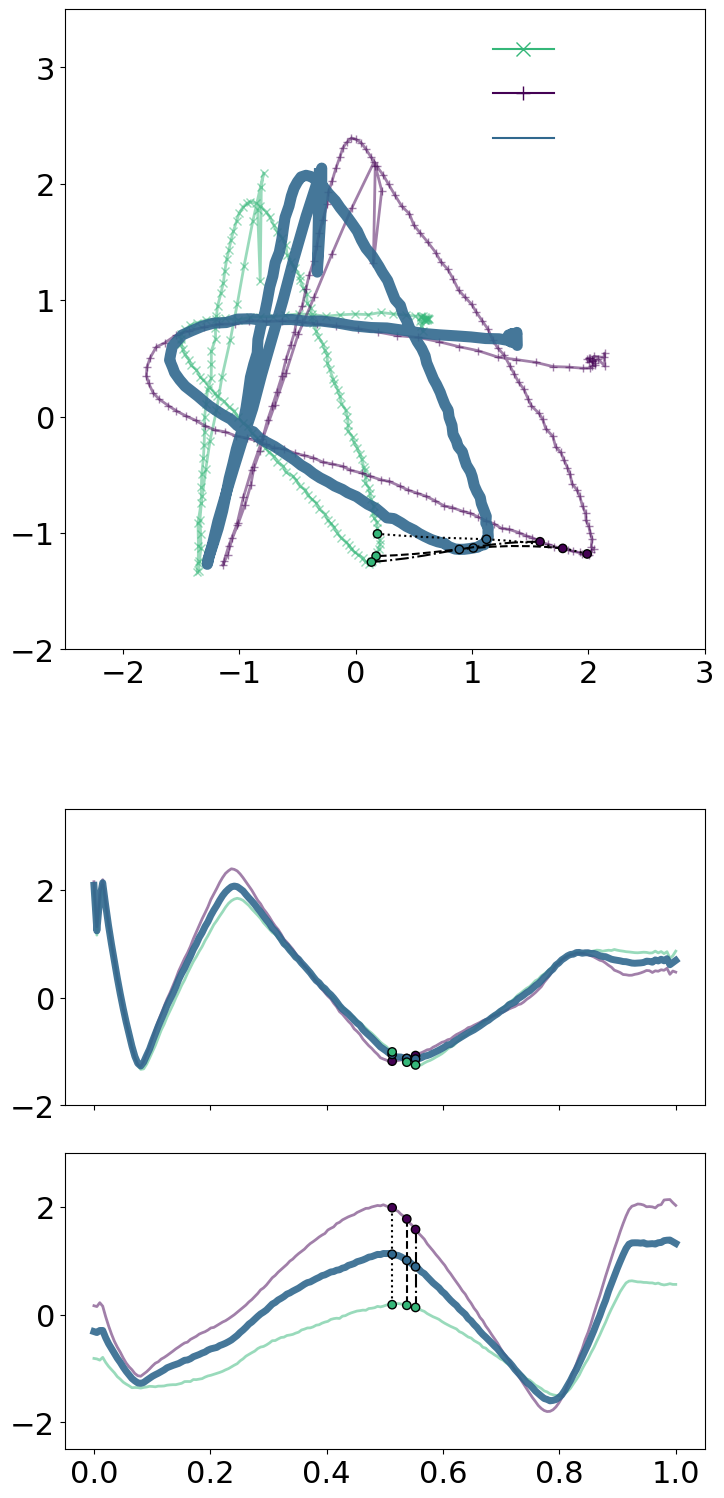

In [14]:
make_plot_from_name("../copiedResults/results/rateinvariantvae/20231113-150209.098322/savedmodel","rateinvariant", [102,107,110])